In [1]:
from datetime import date
from glob import glob
import json
import math
import os
import pickle
import sys
import time

import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy import integrate, interpolate, stats
import pingouin as pg

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

#### Functions

In [5]:
def p_stars(test_pval):
    if test_pval < 0.001:
        return '***'
    elif test_pval < 0.01:
        return '**'
    elif test_pval < 0.05:
        return '*'
    else:
        return 'n.s.'

#### Load Zap_Zip-log_exp to get metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

In [7]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\psilocybin_exp'

### Load subjects

In [8]:
multisub_file = r"C:\Users\lesliec\OneDrive - Allen Institute\data\brain_states_subjects.csv"
subject_df = pd.read_csv(multisub_file, converters={'mouse': str}).astype({'analyze': bool})

In [9]:
subject_df.tail()

,exp_type,mouse,experiment,sweep_states,stim_depth,bad_chs,analyze,data_loc,CCF_res,notes
35,saline,666194,pilot_aw_2023-02-22_12-32-58,saline,deep,"13,14",True,F:\psi_exp\mouse666194\pilot_aw_2023-02-22_12-...,25,NaN
36,saline,666196,pilot_aw_2023-03-15_12-29-06,"awake,saline,saline,saline,saline,saline,salin...",deep,all,True,F:\psi_exp\mouse666196\pilot_aw_2023-03-15_12-...,25,EEG bad?
37,saline,669118,pilot_aw_2023-03-23_12-14-39,"awake,saline,saline,saline,saline,saline,salin...",deep,none,True,F:\psi_exp\mouse669118\pilot_aw_2023-03-23_12-...,25,"only has probe B, F"
38,saline,669117,pilot_aw_2023-03-29_11-09-15,"awake,saline,saline,saline,saline,saline,salin...",deep,"6,9,13,14",True,F:\psi_exp\mouse669117\pilot_aw_2023-03-29_11-...,25,NaN
39,saline,673449,aw_2023-04-21_09-28-23,"awake,saline,saline",deep,"13,14",False,F:\psi_exp\mouse673449\aw_2023-04-21_09-28-23\...,25,evoked responses are very weak in EEG


## Get multi-subject metrics

What psilocybin time window should we look at?? On 5/10, I tested with a 60 minute window. I wanna try a 30 minute window, but I don't want to lose subjects with too few trials.

In [10]:
apply_car = True
call_saline_awake = False

skip_states = ['recovery']
psilocybin_window = 30 * 60 # min to include as "psilocybin" -> seconds
substates = {'resting': True, 'running': False}
trial_threshold = 30 # must have more than this number of trials to be included in analysis
trial_max = 125 # limit some states that have many trials

zlim = 3
PCI_params = {
    'baseline_window': (-0.8, -0.002), # s before stim for baseline, my default: (-0.5, -0.001)
    'response_window': (0.002, 0.8), # s after stim for response, my default: (0.001, 0.5)
    'k': 1.2,
    'min_snr': 1.6, # my default: 1.1
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}

In [ ]:
all_subjects_states_info = []
all_subjects_data = {}
for indi, subrow in subject_df.iterrows():
    if not subrow.analyze:
        print('Skipping {} - {}, experiment excluded from analysis.\n'.format(subrow.mouse, subrow.exp_type))
        continue
    elif subrow.bad_chs == 'all':
        print('Skipping {} - {}, all EEG chs are bad.\n'.format(subrow.mouse, subrow.exp_type))
        continue
    print('{}: {}'.format(subrow.mouse, subrow.experiment))
    if subrow.mouse in all_subjects_data.keys():
        all_subjects_data[subrow.mouse][subrow.exp_type] = {}
    else:
        all_subjects_data[subrow.mouse] = {}
        all_subjects_data[subrow.mouse][subrow.exp_type] = {}
    
    ## Load EEGexp and stim_log ##
    exp = EEGexp(subrow.data_loc, preprocess=False, make_stim_csv=False)
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})

    ### Get all states in experiment ###
    all_sweeps = np.unique(stim_log['sweep'].values)

    ## Get state label for each sweep ##
    sweep_state_list = []
    for char in subrow.sweep_states.split(','):
        sweep_state_list.append(char)
    if len(sweep_state_list) == 1:
        sweep_state_list = sweep_state_list * len(all_sweeps)
    stim_log['state'] = stim_log.apply(lambda x: sweep_state_list[x.sweep], axis=1)
    if call_saline_awake:
        stim_log['state'] = ['awake' if x == 'saline' else x for x in stim_log['state'].values]
    ## Get depth label for each sweep ##
    sweep_depth_list = []
    for char in subrow.stim_depth.split(','):
        sweep_depth_list.append(char)
    if len(sweep_depth_list) == 1:
        sweep_depth_list = sweep_depth_list * len(all_sweeps)
    stim_log['stim_depth'] = stim_log.apply(lambda x: sweep_depth_list[x.sweep], axis=1)
    ## Get list of states and the middle current ##
    states = np.unique(stim_log['state'].values)
    currents = np.unique(stim_log[stim_log['stim_type'] == 'biphasic']['parameter'].values).astype(int)
    if len(currents) > 1:
        ch_curr = str(currents[1])
    else:
        ch_curr = str(currents[0])

    ## Load EEG traces ##
    EEG_sample_rate = exp.ephys_params['EEG']['sample_rate']
    all_EEG_traces = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_EEGtraces.npy'))
    EEG_event_timestamps = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_EEGtraces_times.npy'))
    eeg_chs = np.arange(0, all_EEG_traces.shape[1])
    bad_chs = []
    if subrow.bad_chs != 'none':
        for char in subrow.bad_chs.split(','):
            if char.isdecimal():
                bad_chs.append(int(char))
    GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
    all_subjects_data[subrow.mouse][subrow.exp_type]['good_chs'] = GOOD_CHS
    
    ## Get event_inds ##
    state_event_inds = {}
    for statei in states:
        if statei in skip_states:
            continue
        if statei in ['psilocybin', 'saline']:
            exp_meta = metadata[(
                (metadata['mouse_name'].str.contains(subrow.mouse)) &
                (metadata['exp_name'].str.contains(subrow.experiment))
            )].squeeze()
            stim_log['onset_from_inj2'] = stim_log['onset'] - float(exp_meta['Second injection time'])
            for substi, trialtest in substates.items():
                event_inds = stim_log[
                    (stim_log['stim_type'] == 'biphasic') &
                    (stim_log['parameter'] == ch_curr) &
                    (stim_log['stim_depth'] == 'deep') &
                    (stim_log['good'] == True) &
                    (stim_log['resting_trial'] == trialtest) &
                    (stim_log['state'] == statei) &
                    (stim_log['onset_from_inj2'] < psilocybin_window)
                ].index.values
                state_event_inds[statei + '_' + substi] = event_inds
        elif statei == 'awake':
            for substi, trialtest in substates.items():
                event_inds = stim_log[
                    (stim_log['stim_type'] == 'biphasic') &
                    (stim_log['parameter'] == ch_curr) &
                    (stim_log['stim_depth'] == 'deep') &
                    (stim_log['good'] == True) &
                    (stim_log['resting_trial'] == trialtest) &
                    (stim_log['state'] == statei)
                ].index.values
                state_event_inds[statei + '_' + substi] = event_inds
        else:
            event_inds = stim_log[
                (stim_log['stim_type'] == 'biphasic') &
                (stim_log['parameter'] == ch_curr) &
                (stim_log['stim_depth'] == 'deep') &
                (stim_log['good'] == True) &
                (stim_log['resting_trial'] == True) &
                (stim_log['state'] == statei)
            ].index.values
            state_event_inds[statei] = event_inds
            
    EEG_traces = {}
    print(' Processing ERPs for all states...')
    for statei, event_inds in state_event_inds.items():
        if len(event_inds) < trial_threshold:
            print(' Only {:d} trials for {} state, not analyzing.'.format(len(event_inds), statei))
            continue
        elif len(event_inds) > trial_max:
            print(' {} has {:d} trials, downsampling trials to {:d}.'.format(statei, len(event_inds), trial_max))
            event_inds = np.random.choice(event_inds, size=trial_max, replace=False)
        
        ## Get event-related EEG traces ##
        event_traces = all_EEG_traces[:, :, event_inds]
        if apply_car:
            event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
        EEG_traces[statei] = [EEG_event_timestamps, event_traces]
        
        state_ERP = np.mean(event_traces, axis=2)[:, GOOD_CHS]
        ## Calculate global field power duration ##
        gfpow = np.std(state_ERP, axis=1)
        blmean = np.mean(gfpow[EEG_event_timestamps < 0])
        blstd = np.std(gfpow[EEG_event_timestamps < 0])
        zgfpow = (gfpow - blmean) / blstd
        response_duration = np.sum(zgfpow[EEG_event_timestamps > 0] > zlim) / EEG_sample_rate
        ## Area under global field power curve ##
        zerp = np.where((zgfpow[EEG_event_timestamps > 0] - zlim) >= 0, (zgfpow[EEG_event_timestamps > 0] - zlim), 0.)
        auc = integrate.simps(zerp, EEG_event_timestamps[EEG_event_timestamps > 0], axis=0, even='last')
        ## Calulate PCIst ##
        PCIval = calc_PCIst(state_ERP.T, EEG_event_timestamps, **PCI_params)
        
        all_subjects_states_info.append([
            subrow.mouse, subrow.exp_type, statei, len(event_inds), len(GOOD_CHS), response_duration, auc, PCIval
        ])
        
    all_subjects_data[subrow.mouse][subrow.exp_type]['EEG_traces'] = EEG_traces
    print('')
all_subs_unit_stats_df = pd.DataFrame(all_subjects_states_info, columns=[
    'mouse', 'exp_type', 'state', 'trial_count', 'EEG_ch_count', 'ERP_duration', 'ERP_magnitude', 'ERP_PCI'
])

Skipping 657903 - psilocybin, experiment excluded from analysis.

Skipping 666193 - psilocybin, all EEG chs are bad.

666194: pilot_aw_psi_2023-02-23_10-40-34
Experiment type: electrical stimulation


In [12]:
all_subs_unit_stats_df.head()

,mouse,exp_type,state,trial_count,EEG_ch_count,ERP_duration,ERP_magnitude,ERP_PCI
0,666194,psilocybin,psilocybin_resting,125,30,0.9436,11.249105,65.056341
1,666194,psilocybin,psilocybin_running,53,30,0.3852,3.642292,71.939348
2,669118,psilocybin,awake_running,117,30,0.2616,1.510345,39.097243
3,669118,psilocybin,psilocybin_running,125,30,0.1764,0.679407,19.429373
4,669117,psilocybin,awake_resting,98,26,0.2144,1.229165,18.885514


Some subjects will have multiple 'awake' states, which to plot?

In [15]:
subi = '676727'
subdf = all_subs_unit_stats_df[all_subs_unit_stats_df['mouse'] == subi]
subdf

,mouse,exp_type,state,trial_count,EEG_ch_count,ERP_duration,ERP_magnitude,ERP_PCI
12,676727,psilocybin,awake_running,107,29,0.4840,9.273998,58.071278
13,676727,psilocybin,psilocybin_running,125,29,0.4940,6.255095,36.184561
23,676727,urethane,urethane,125,29,0.5544,2.897416,25.915689
24,676727,isoflurane,awake_resting,92,29,0.3244,1.490322,37.774737
25,676727,isoflurane,isoflurane,119,29,0.0676,0.380875,31.624160


In [16]:
statei = 'psilocybin_running'
statedf = all_subs_unit_stats_df[all_subs_unit_stats_df['state'] == statei]
statedf

,mouse,exp_type,state,trial_count,EEG_ch_count,ERP_duration,ERP_magnitude,ERP_PCI
1,666194,psilocybin,psilocybin_running,53,30,0.3852,3.642292,71.939348
3,669118,psilocybin,psilocybin_running,125,30,0.2132,0.817707,23.040301
6,669117,psilocybin,psilocybin_running,52,26,0.0704,0.215250,0.000000
9,673449,psilocybin,psilocybin_running,36,28,0.2120,0.583281,52.945263
11,676726,psilocybin,psilocybin_running,125,29,0.2756,2.009446,34.875689
13,676727,psilocybin,psilocybin_running,125,29,0.4940,6.255095,36.184561


Removing bad subjects, or duplicate states

### Stats

In [17]:
sigalpha = 0.05

In [18]:
## Normality tests ##
plstates = ['awake_resting', 'psilocybin_resting', 'awake_running', 'psilocybin_running', 'isoflurane', 'urethane']
PCI_vals = []
for statei in plstates:
    stPCIvals = all_subs_unit_stats_df['ERP_PCI'][all_subs_unit_stats_df['state'] == statei].values
    PCI_vals.append(stPCIvals)
    print('{}: N={:d} mice'.format(statei, len(stPCIvals)))
    ## Shapiro-Wilk test ##
    if len(stPCIvals) > 2:
        swstat, swp = stats.shapiro(stPCIvals)
        if swp < sigalpha:
            print('  Shapiro-Wilk test: NOT normal')
        else:
            print('  Shapiro-Wilk test: normal')
    else:
        print('  Too few subjects, cannot run Shapiro-Wilk test')
    print(' mean={:.1f}, SEM={:.1f}\n'.format(np.mean(stPCIvals), np.std(stPCIvals)/np.sqrt(len(stPCIvals))))

awake_resting: N=16 mice
  Shapiro-Wilk test: normal
 mean=43.7, SEM=4.0

psilocybin_resting: N=3 mice
  Shapiro-Wilk test: normal
 mean=38.0, SEM=12.4

awake_running: N=9 mice
  Shapiro-Wilk test: normal
 mean=46.7, SEM=4.5

psilocybin_running: N=6 mice
  Shapiro-Wilk test: normal
 mean=36.5, SEM=9.2

isoflurane: N=11 mice
  Shapiro-Wilk test: normal
 mean=16.6, SEM=2.4

urethane: N=10 mice
  Shapiro-Wilk test: normal
 mean=22.8, SEM=3.9



Have to perform a one-way ANOVA instead of a repeated measures ANOVA, since not all mice have all states.

In [19]:
PCI_ANOVA = pg.anova(data=all_subs_unit_stats_df, dv='ERP_PCI', between='state', detailed=True)
PCI_ANOVA

,Source,SS,DF,MS,F,p-unc,np2
0,state,7632.701581,5,1526.540316,6.034631,0.000199,0.381103
1,Within,12395.203536,49,252.963337,NaN,NaN,NaN


In [20]:
print('all states PCI ANOVA p-val = {:.3E}'.format(PCI_ANOVA['p-unc'].values[0]))
if PCI_ANOVA['p-unc'].values[0] < sigalpha:
    print('There is a significant effect of state on PCI, now perform posthoc tests.')
    PCI_posthoc = pg.pairwise_tests(
        data=all_subs_unit_stats_df, dv='ERP_PCI', between='state', padjust='fdr_bh')

all states PCI ANOVA p-val = 1.993E-04
There is a significant effect of state on PCI, now perform posthoc tests.


In [21]:
PCI_posthoc

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,state,awake_resting,awake_running,False,True,-0.470059,19.061825,two-sided,0.643646,0.742668,fdr_bh,0.41,-0.180918
1,state,awake_resting,isoflurane,False,True,5.563726,23.338413,two-sided,0.000011,0.000166,fdr_bh,1674.363,1.884092
2,state,awake_resting,psilocybin_resting,False,True,0.367452,2.310849,two-sided,0.744257,0.797419,fdr_bh,0.511,0.305854
3,state,awake_resting,psilocybin_running,False,True,0.664400,6.789119,two-sided,0.528346,0.720472,fdr_bh,0.483,0.367032
4,state,awake_resting,urethane,False,True,3.602893,22.741009,two-sided,0.001519,0.005698,fdr_bh,22.801,1.324039
5,state,awake_running,isoflurane,False,True,5.598127,12.397128,two-sided,0.000103,0.000774,fdr_bh,618.536,2.536621
6,state,awake_running,psilocybin_resting,False,True,0.550259,2.403501,two-sided,0.629055,0.742668,fdr_bh,0.554,0.466288
7,state,awake_running,psilocybin_running,False,True,0.916930,7.237106,two-sided,0.388713,0.635646,fdr_bh,0.582,0.507356
8,state,awake_running,urethane,False,True,3.832994,16.284846,two-sided,0.001426,0.005698,fdr_bh,23.803,1.691547
9,state,isoflurane,psilocybin_resting,False,True,-1.386045,2.112233,two-sided,0.293913,0.551087,fdr_bh,0.864,-1.514509


In [22]:
sigdf = PCI_posthoc[PCI_posthoc['p-corr'] < sigalpha]
sigdf

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
1,state,awake_resting,isoflurane,False,True,5.563726,23.338413,two-sided,0.000011,0.000166,fdr_bh,1674.363,1.884092
4,state,awake_resting,urethane,False,True,3.602893,22.741009,two-sided,0.001519,0.005698,fdr_bh,22.801,1.324039
5,state,awake_running,isoflurane,False,True,5.598127,12.397128,two-sided,0.000103,0.000774,fdr_bh,618.536,2.536621
8,state,awake_running,urethane,False,True,3.832994,16.284846,two-sided,0.001426,0.005698,fdr_bh,23.803,1.691547


### Plot

PCI

<IPython.core.display.Javascript object>


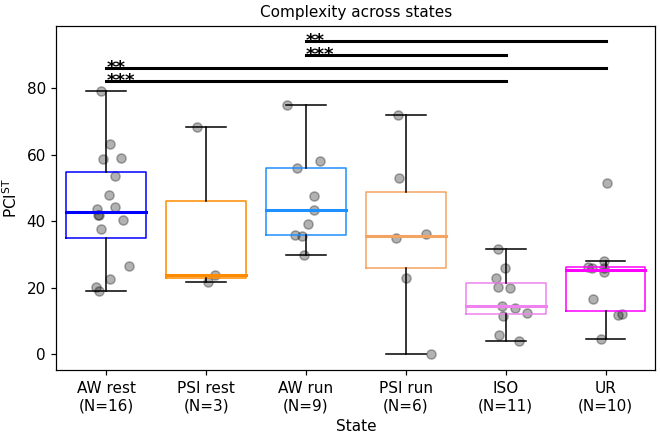

In [23]:
plot_states = ['awake_resting', 'psilocybin_resting', 'awake_running', 'psilocybin_running', 'isoflurane', 'urethane']
st_labels = ['AW rest', 'PSI rest', 'AW run', 'PSI run', 'ISO', 'UR']
st_colors = ['blue', 'darkorange', 'dodgerblue', 'sandybrown', 'violet', 'magenta']

fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

xlabels = []
for ii, statei in enumerate(plot_states):
    statedf = all_subs_unit_stats_df[all_subs_unit_stats_df['state'] == statei]
    xs = np.random.normal(ii, 0.1, len(statedf)) # np.zeros(len(statedf)) + ii
    ax.boxplot(
        statedf['ERP_PCI'].values, positions=[ii], widths=[0.8], showfliers=False,
        medianprops={'color': st_colors[ii], 'linewidth': 2}, boxprops={'color': st_colors[ii]}
    )
    ax.scatter(xs, statedf['ERP_PCI'].values, c='k', marker='o', alpha=0.3)
    xlabels.append('{}\n(N={:d})'.format(st_labels[ii], len(statedf)))
    
## Add subject lines ##
# for subi in np.unique(all_subs_unit_stats_df['mouse'].values):
#     subdf = all_subs_unit_stats_df[all_subs_unit_stats_df['mouse'] == subi]
#     if len(subdf) > 1:
#         tempvals = np.zeros(len(plot_states), dtype=float)
#         for ii, statei in enumerate(plot_states):
#             if statei in subdf['state'].values:
#                 tempvals[ii] = subdf[subdf['state'] == statei]['ERP_PCI']
#             else:
#                 tempvals[ii] = np.nan
#     for ii in range(len(plot_states) - 1):
#         ax.plot([ii, ii+1], tempvals[ii:ii+2], color='k', linewidth=1.0, alpha=0.5)
        
## Add stats ##
for (indi, sigrow), yval in zip(sigdf.iterrows(), [82, 86, 90, 94]):
    xA = np.nonzero(np.array(plot_states) == sigrow.A)[0][0]
    xB = np.nonzero(np.array(plot_states) == sigrow.B)[0][0]
    ax.plot([xA, xB], [yval, yval], color='k', linewidth=2)
    ax.annotate(
        p_stars(sigrow['p-corr']), xy=(np.min([xA, xB]), yval), xycoords='data', # np.min([xA, xB]); (xA + xB)/2
        fontsize=12, fontweight='bold', ha='left', va='center'
    )
        
ax.set_xticklabels(xlabels)
ax.set_xlabel('State')
ax.set_ylabel('$\mathregular{PCI^{ST}}$')
ax.set_title('Complexity across states')

## Save ##
figname = 'PCI_allstates_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

Plot other ERP metrics

### Plot example ERPs for all states

<IPython.core.display.Javascript object>


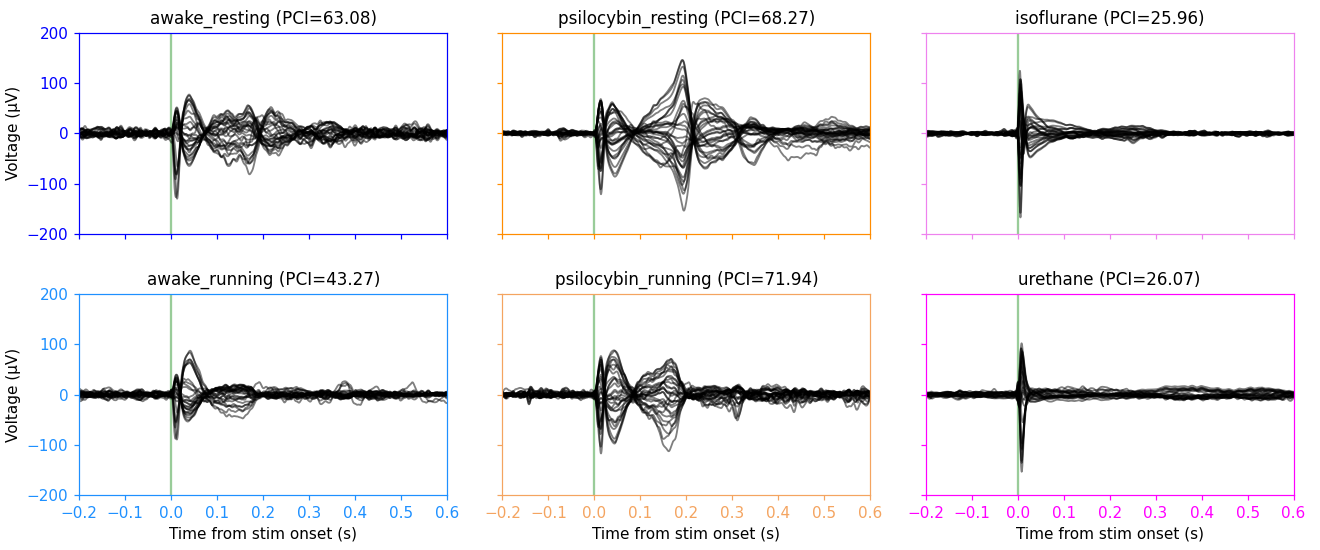

In [37]:
state_examples = {
    'awake_resting': ['666194', 'saline', 'blue'],
    'psilocybin_resting': ['666194', 'psilocybin', 'darkorange'],
    'isoflurane': ['551397', 'isoflurane', 'violet'],
    'awake_running': ['666194', 'saline', 'dodgerblue'],
    'psilocybin_running': ['666194', 'psilocybin', 'sandybrown'],
    'urethane': ['654182', 'urethane', 'magenta'],
}

plot_window = [-0.2, 0.6]
y_limit = [-200, 200]

fig = plt.figure(figsize=(12, 5))
axs = fig.add_gridspec(
    ncols=3, nrows=2, left=0.06, right=0.98, top=0.94, bottom=0.1, hspace=0.3, wspace=0.15
).subplots(sharex=True, sharey=True)

for ax, (statei, state_info) in zip(axs.flatten(), state_examples.items()):
    good_chs = all_subjects_data[state_info[0]][state_info[1]]['good_chs']
    timex = all_subjects_data[state_info[0]][state_info[1]]['EEG_traces'][statei][0]
    traces = np.mean(all_subjects_data[state_info[0]][state_info[1]]['EEG_traces'][statei][1], axis=2)
    PCIval = all_subs_unit_stats_df[
        (all_subs_unit_stats_df['mouse'] == state_info[0]) &
        (all_subs_unit_stats_df['exp_type'] == state_info[1]) &
        (all_subs_unit_stats_df['state'] == statei)
    ]['ERP_PCI'].values[0]
    
    ax.axvline(0, color='g', alpha=0.4)
    ax.plot(timex, traces[:, good_chs], color='k', linewidth=1.2, alpha=0.5)
#     ax.plot(timex, traces[:, good_chs], color=state_info[2], linewidth=1.2, alpha=0.5)
#     for axspine in ['top', 'bottom', 'left', 'right']:
#         ax.spines[axspine].set_color(state_info[2])
#     ax.tick_params(axis='x', colors=state_info[2])
#     ax.tick_params(axis='y', colors=state_info[2])
#     ax.set_title('{}'.format(statei), fontsize=11)
    ax.set_title('{} (PCI={:.2f})'.format(statei, PCIval), fontsize=11)
    
axs[0,0].set_xlim(plot_window)
axs[0,0].set_ylim(y_limit)
axs[1,0].set_xlabel('Time from stim onset (s)')
axs[1,1].set_xlabel('Time from stim onset (s)')
axs[1,2].set_xlabel('Time from stim onset (s)')
axs[0,0].set_ylabel('Voltage (\u03bcV)')
axs[1,0].set_ylabel('Voltage (\u03bcV)')

## Save ##
figname = 'example_ERPs_allstates_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False, dpi=300)

### Plot ERP butterfly plots (per subject)

In [22]:
subi = '669117'
expi = 'saline'
good_chs = all_subjects_data[subi][expi]['good_chs']
all_EEG_traces = all_subjects_data[subi][expi]['EEG_traces']
print(all_EEG_traces.keys())

dict_keys(['awake_resting', 'awake_running'])


<IPython.core.display.Javascript object>


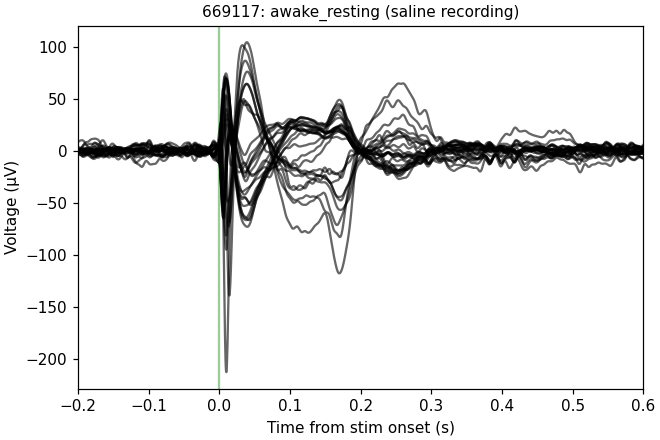

Text(0.5, 1.0, '669117: awake_resting (saline recording)')

In [30]:
statei = 'awake_resting'
plot_window = [-0.2, 0.6]

timex = all_EEG_traces[statei][0]
traces = np.mean(all_EEG_traces[statei][1], axis=2)

fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
ax.axvline(0, color='g', alpha=0.4)
ax.plot(timex, traces[:, good_chs], color='k', linewidth=1.5, alpha=0.6)

ax.set_xlim(plot_window)
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (\u03bcV)')

ax.set_title('{}: {} ({} recording)'.format(subi, statei, expi))

Plot all states, all days

In [24]:
subi = '676727'
subdf = all_subs_unit_stats_df[all_subs_unit_stats_df['mouse'] == subi]
subdf

,mouse,exp_type,state,trial_count,EEG_ch_count,ERP_duration,ERP_magnitude,ERP_PCI
12,676727,psilocybin,awake_running,107,29,0.4840,9.273998,58.071278
13,676727,psilocybin,psilocybin_running,125,29,0.4940,6.255095,36.184561
23,676727,urethane,urethane,125,29,0.5544,2.897416,25.915689
24,676727,isoflurane,awake_resting,92,29,0.3244,1.490322,37.774737
25,676727,isoflurane,isoflurane,119,29,0.0676,0.380875,31.624160


In [25]:
exp_days = np.unique(subdf['exp_type'].values)
print(exp_days)

['isoflurane' 'psilocybin' 'urethane']


In [26]:
[len(subdf[subdf['exp_type'] == x]) for x in exp_days]

[2, 2, 1]

<IPython.core.display.Javascript object>


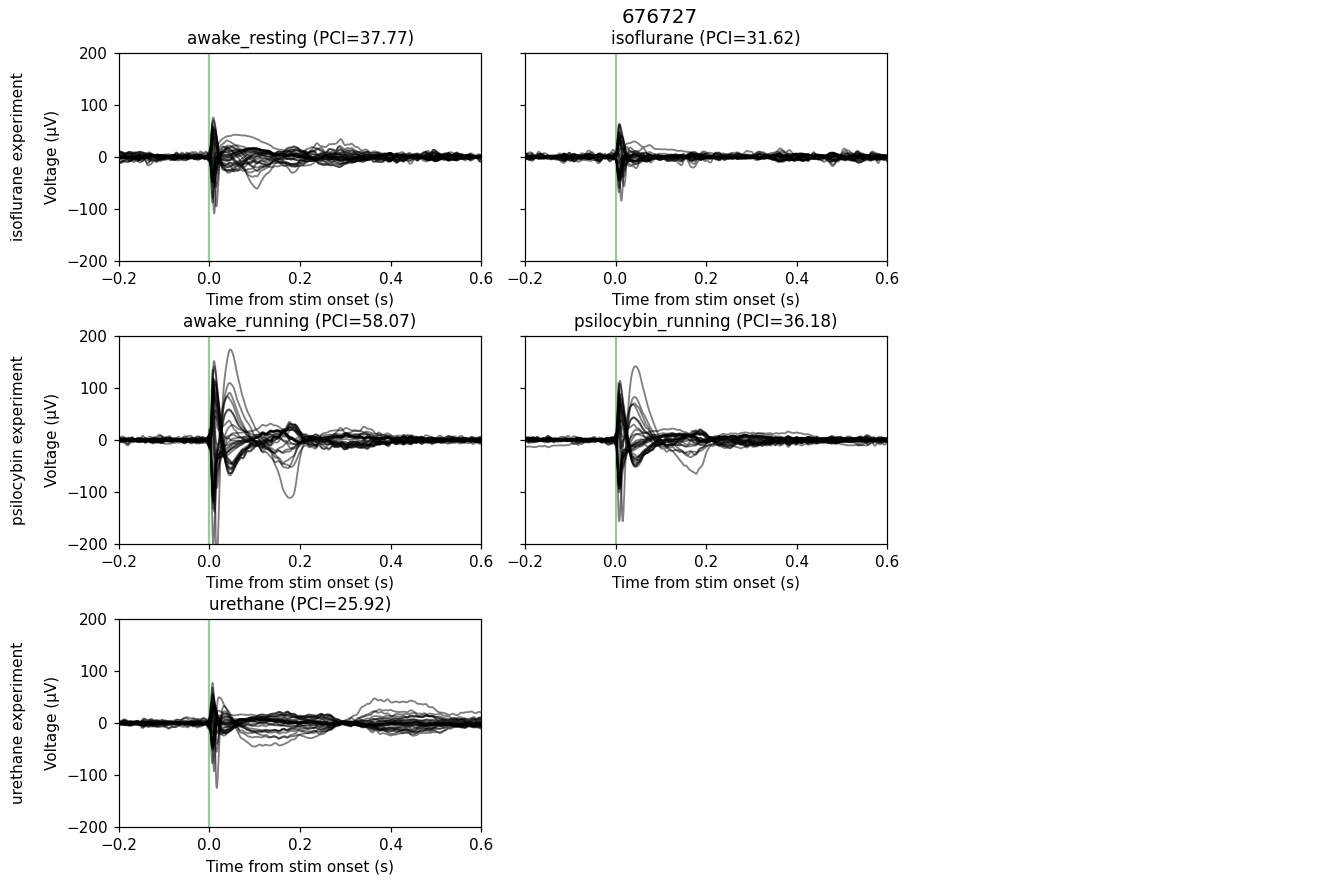

In [27]:
plot_window = [-0.2, 0.6]
y_limit = [-200, 200]

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(ncols=3, nrows=3, left=0.09, right=0.98, top=0.94, bottom=0.06, hspace=0.36, wspace=0.12)

for ii, exp_type in enumerate(exp_days):
    statedf = subdf[subdf['exp_type'] == exp_type]
    for jj, statei in enumerate(np.unique(statedf['state'].values)):
        timex = all_subjects_data[subi][exp_type]['EEG_traces'][statei][0]
        traces = np.mean(all_subjects_data[subi][exp_type]['EEG_traces'][statei][1], axis=2)
        PCIval = statedf[statedf['state'] == statei].squeeze()['ERP_PCI']

        ax = fig.add_subplot(gs[ii, jj])
        ax.axvline(0, color='g', alpha=0.4)
        ax.plot(timex, traces[:, all_subjects_data[subi][exp_type]['good_chs']], color='k', linewidth=1.2, alpha=0.5)
        
        ax.set_xlim(plot_window)
        ax.set_ylim(y_limit)
        ax.set_xlabel('Time from stim onset (s)')
        ax.set_title('{} (PCI={:.2f})'.format(statei, PCIval), fontsize=11)
        if jj == 0:
            ax.set_ylabel('{} experiment\n\nVoltage (\u03bcV)'.format(exp_type))
        else:
            ax.set_yticklabels([])
                        
## Title ##
fig.text(0.5, 0.98, subi, rotation='horizontal', va='center', ha='center', fontsize=13)
## Save ##
figname = '{}_ERPs_allstates.png'.format(subi)
# fig.savefig(os.path.join(plotsdir, 'ERP_allstates', figname), transparent=False, dpi=300)

### Plot ERPs for all subjects/states

666194: max states in one day = 2


<IPython.core.display.Javascript object>


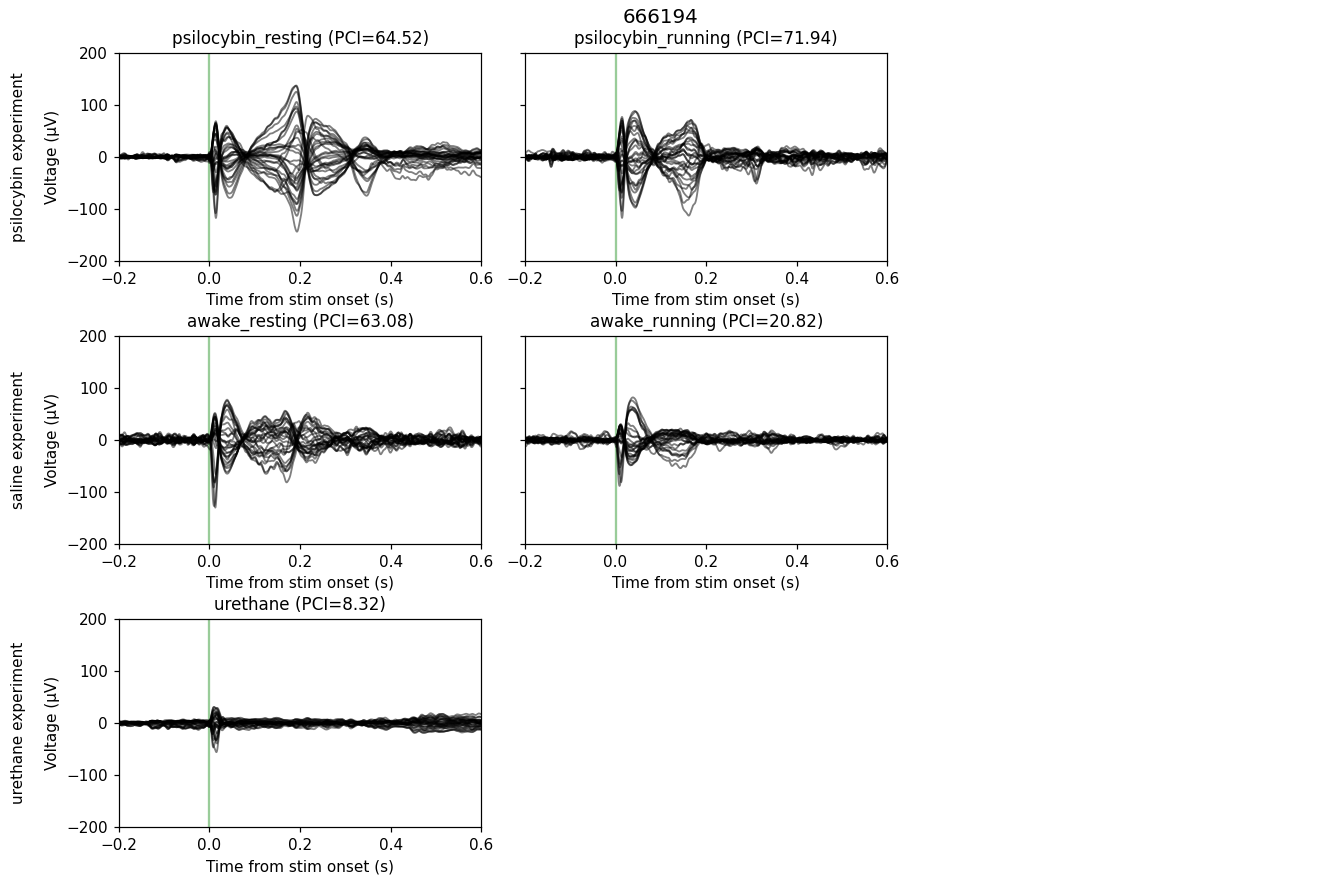

669118: max states in one day = 2


<IPython.core.display.Javascript object>


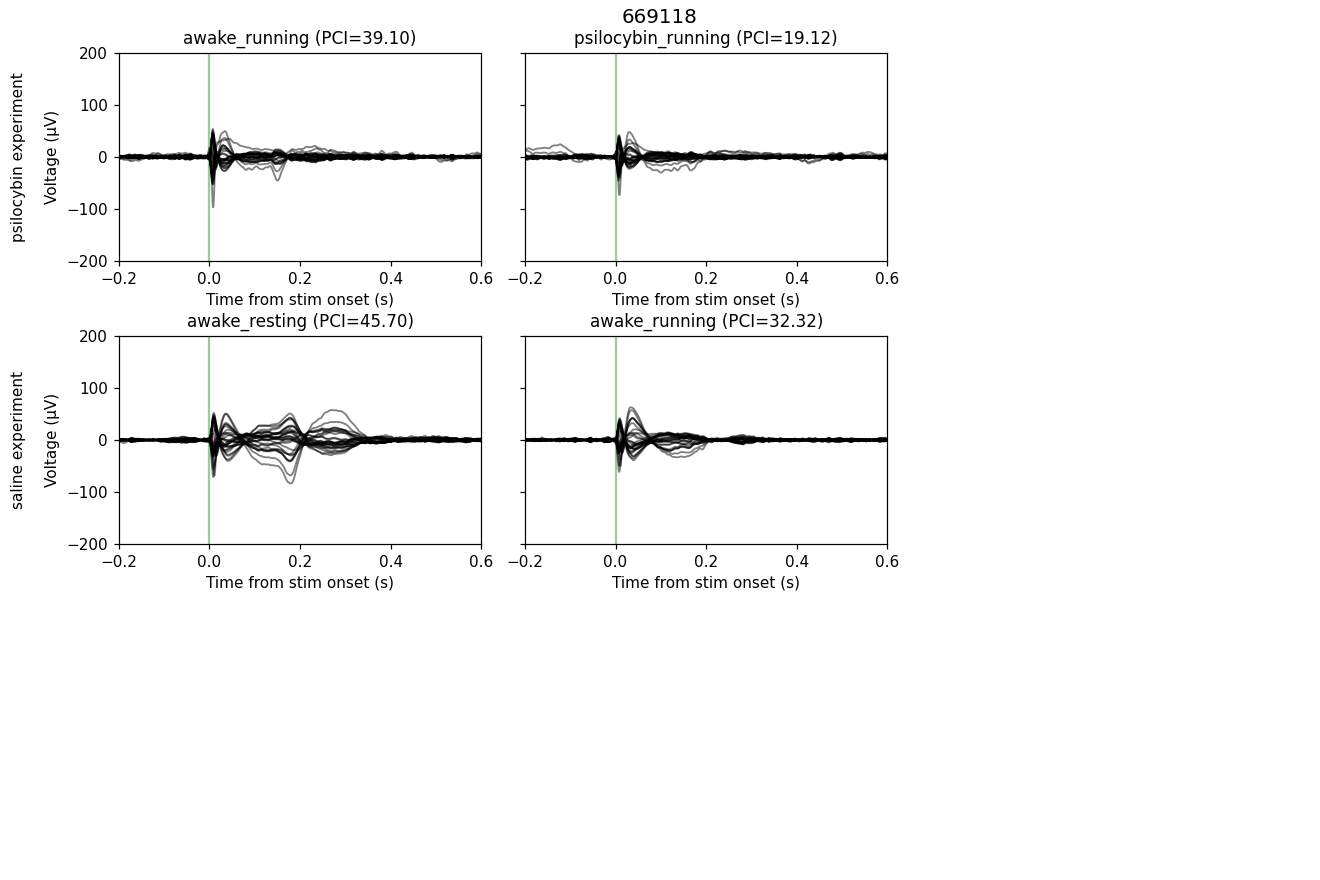

669117: max states in one day = 3


<IPython.core.display.Javascript object>


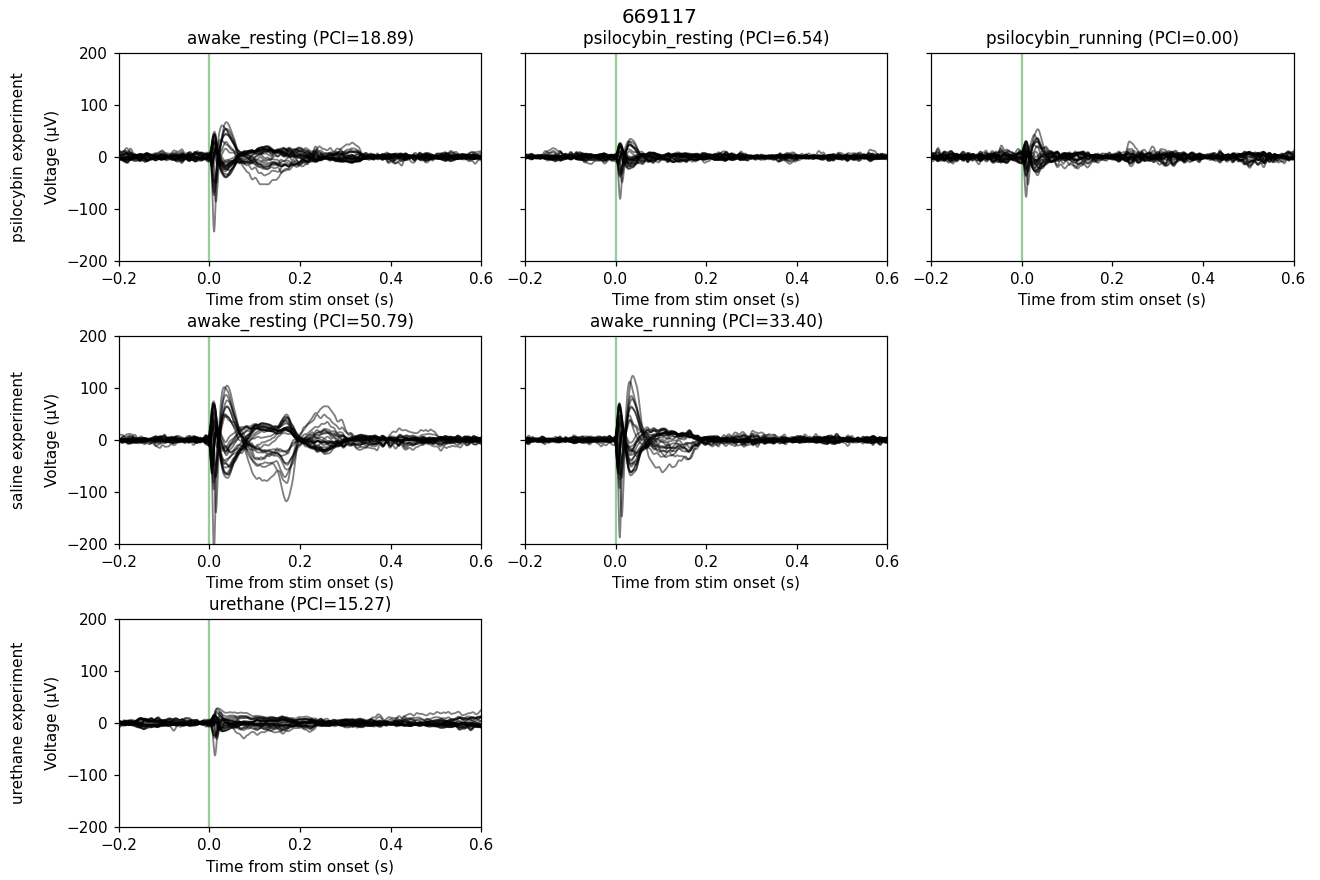

673449: max states in one day = 3


<IPython.core.display.Javascript object>


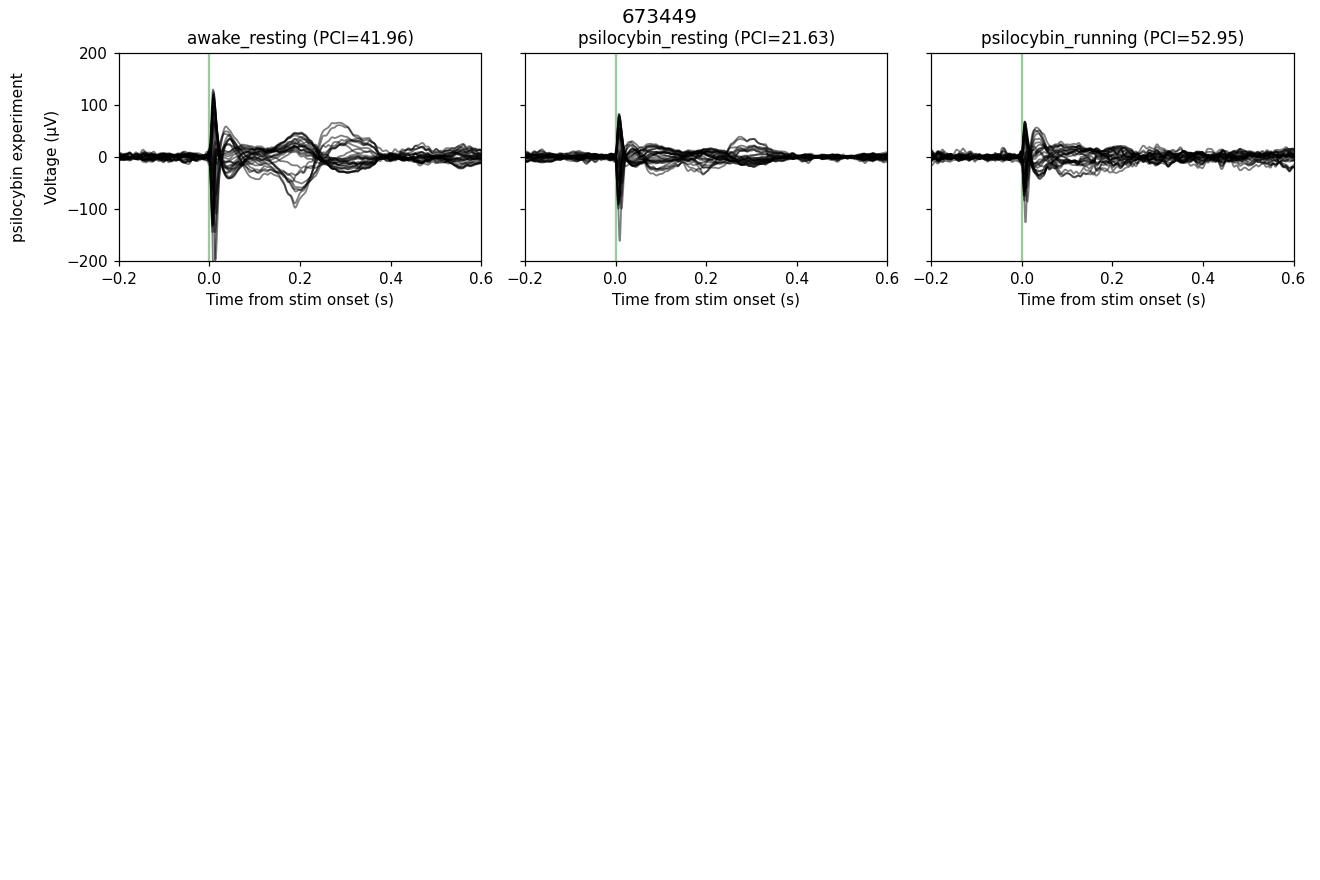

676726: max states in one day = 3


<IPython.core.display.Javascript object>


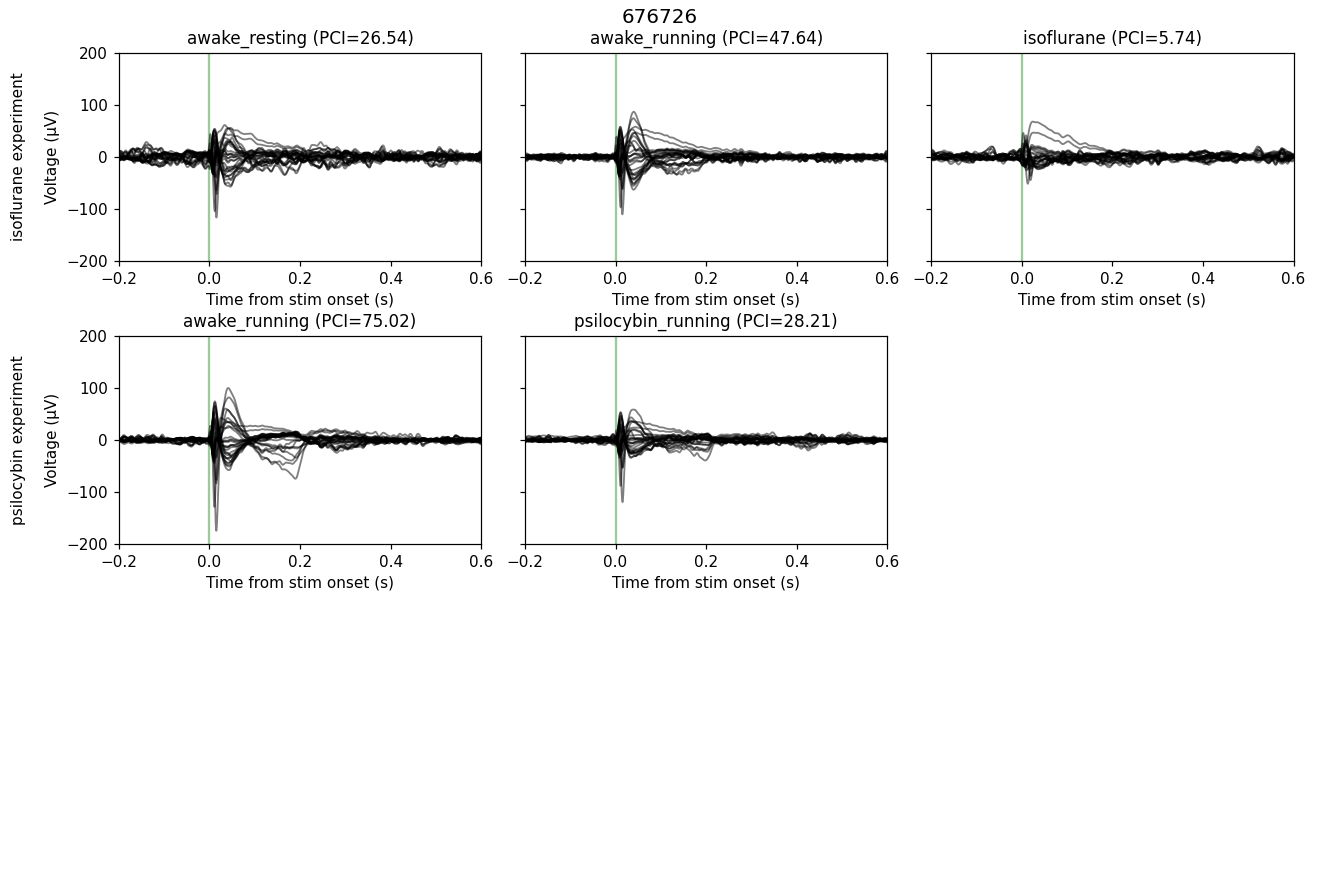

582386: max states in one day = 1


<IPython.core.display.Javascript object>


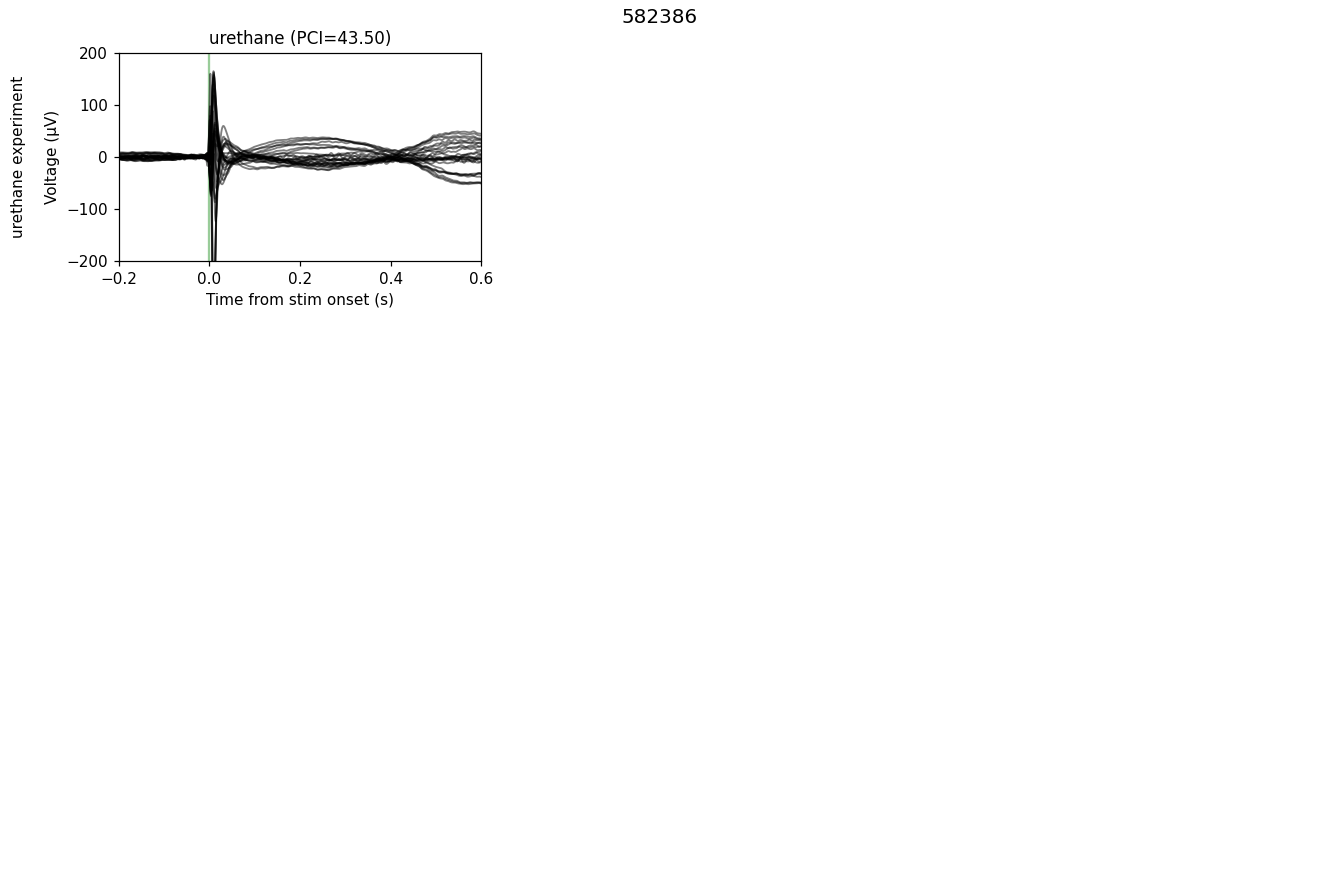

638703: max states in one day = 1


<IPython.core.display.Javascript object>


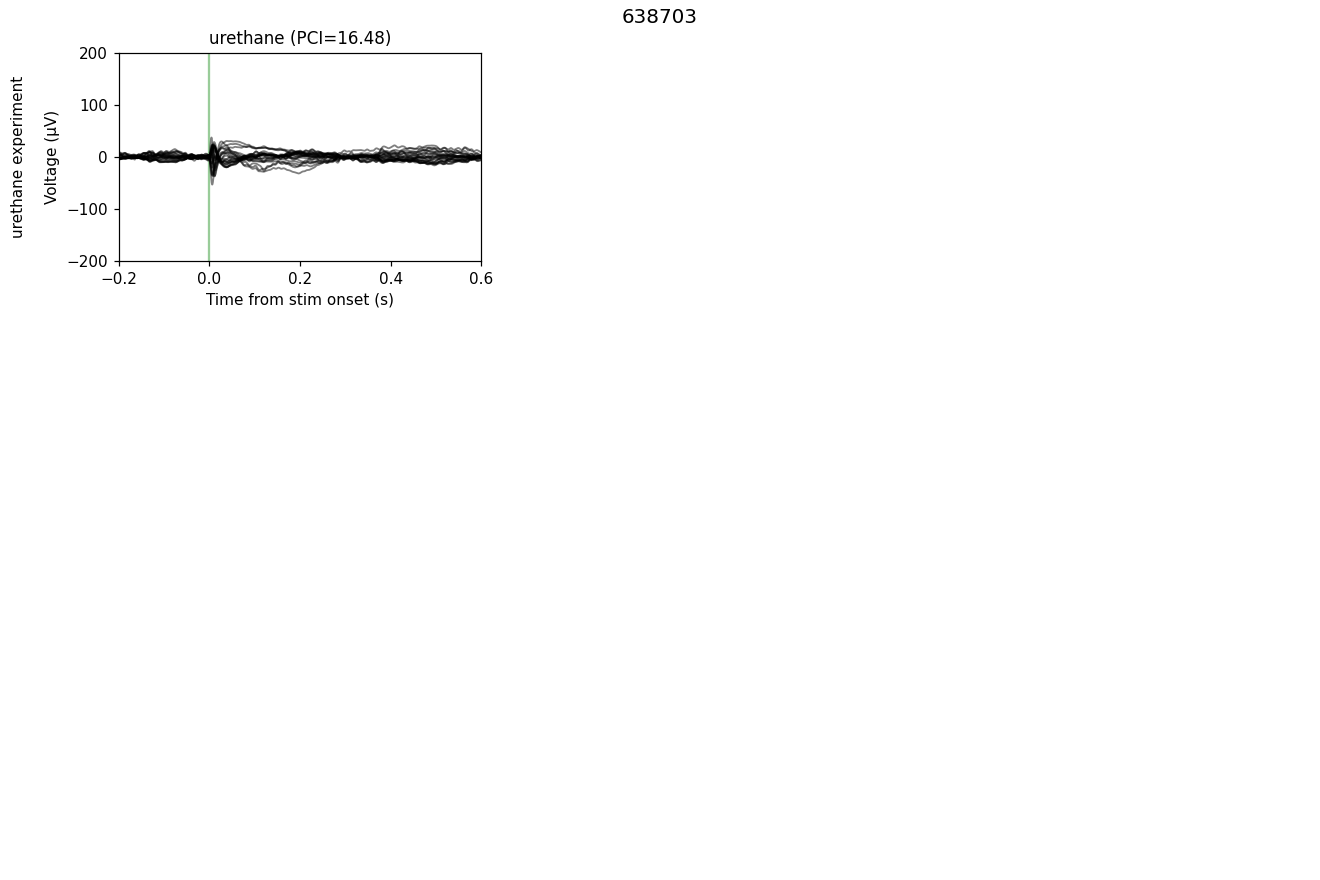

654181: max states in one day = 3


<IPython.core.display.Javascript object>


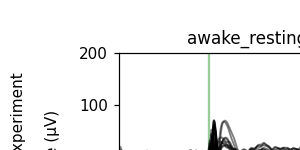

654182: max states in one day = 1


<IPython.core.display.Javascript object>


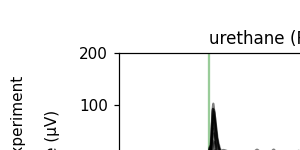

631037: max states in one day = 1


<IPython.core.display.Javascript object>


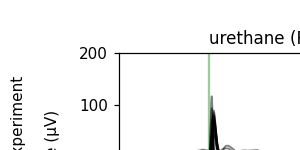

655955: max states in one day = 1


<IPython.core.display.Javascript object>


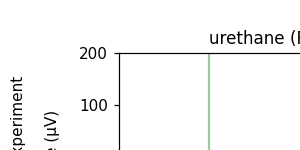

655956: max states in one day = 1


<IPython.core.display.Javascript object>


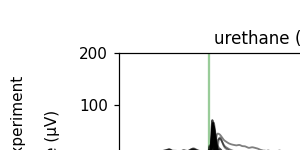

551397: max states in one day = 2


<IPython.core.display.Javascript object>


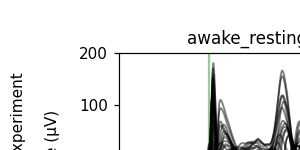

551399: max states in one day = 2


<IPython.core.display.Javascript object>


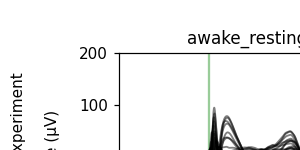

569062: max states in one day = 2


<IPython.core.display.Javascript object>


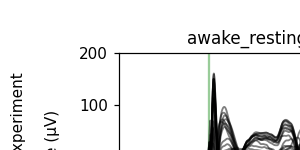

569064: max states in one day = 2


<IPython.core.display.Javascript object>


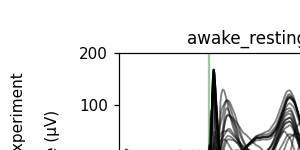

569068: max states in one day = 2


<IPython.core.display.Javascript object>


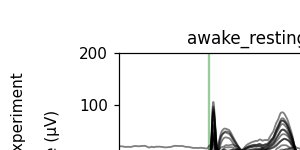

569069: max states in one day = 3


<IPython.core.display.Javascript object>


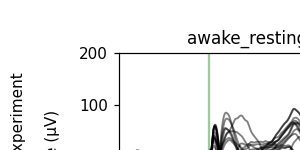

569073: max states in one day = 2


<IPython.core.display.Javascript object>


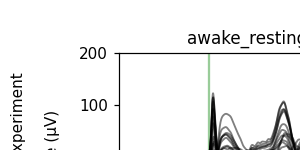

571619: max states in one day = 2


<IPython.core.display.Javascript object>


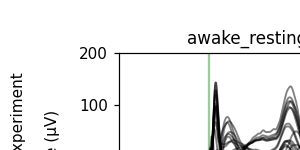

In [74]:
plot_window = [-0.2, 0.6]
y_limit = [-200, 200]

for subi, subject_dict in all_subjects_data.items():
    subdf = all_subs_unit_stats_df[all_subs_unit_stats_df['mouse'] == subi]
    exp_days = np.unique(subdf['exp_type'].values)
    max_states = np.max([len(subdf[subdf['exp_type'] == x]) for x in exp_days])
    print('{}: max states in one day = {:d}'.format(subi, max_states))
    
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(ncols=3, nrows=3, left=0.09, right=0.98, top=0.94, bottom=0.06, hspace=0.36, wspace=0.12)

    for ii, exp_type in enumerate(exp_days):
        statedf = subdf[subdf['exp_type'] == exp_type]
        for jj, statei in enumerate(np.unique(statedf['state'].values)):
            timex = subject_dict[exp_type]['EEG_traces'][statei][0]
            traces = np.mean(subject_dict[exp_type]['EEG_traces'][statei][1], axis=2)
            PCIval = statedf[statedf['state'] == statei].squeeze()['ERP_PCI']

            ax = fig.add_subplot(gs[ii, jj])
            ax.axvline(0, color='g', alpha=0.4)
            ax.plot(timex, traces[:, subject_dict[exp_type]['good_chs']], color='k', linewidth=1.2, alpha=0.5)

            ax.set_xlim(plot_window)
            ax.set_ylim(y_limit)
            ax.set_xlabel('Time from stim onset (s)')
            ax.set_title('{} (PCI={:.2f})'.format(statei, PCIval), fontsize=11)
            if jj == 0:
                ax.set_ylabel('{} experiment\n\nVoltage (\u03bcV)'.format(exp_type))
            else:
                ax.set_yticklabels([])

    ## Title ##
    fig.text(0.5, 0.98, subi, rotation='horizontal', va='center', ha='center', fontsize=13)
    ## Save ##
    figname = '{}_ERPs_allstates.png'.format(subi)
#     fig.savefig(os.path.join(plotsdir, 'ERP_allstates', figname), transparent=False, dpi=300)